This notebook demonstrates the usage of the resilience/socio-economic capacity model.

# Loading functions

We first import function librairies. The first ones are standard python librairies.

In [1]:
#The main library we use. Manipulates Excel-like tables (called dataframes) with named rows and columns
import pandas as pd 

In [2]:
#ploting capacities
import matplotlib.pyplot as plt 
#make plots appear in this notebook
%matplotlib inline  

#Default options for plots: this controls the font used in figures
font = {'family' : 'sans serif',
    'size'   : 18}
plt.rc('font', **font)


# Loading and exploring the data

Here we read the data set we need into a pandas table (called DataFrame).
This specific dataset was put together from a variety of different sources using another python notebook: [data_gathering_demo.ipynb](data_gathering_demo.ipynb). In the future we could build directly an excel file with all the data the model needs.

In [3]:
 #Let's first have a look at the Excel file
pd.read_excel("inputs/all_data_compiled.xlsx").head()

,description,Average income in the province,Population,Poverty incidence,Access to early warning,National GDP per capita,Average income of the province (relative to national),Relative income of poor families,National population,Access to finance for poor people,...,Asset vulnerability (non-poor people),Hazard (protection),Productivity of capital,Time to reconstruct,Avoided losses with early warning,Risk transferred nationally,Effective scale up for non-poor people,Effective scale up for poor people,Elasticity of utility,Discount rate
0,variable,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,national_pop,axfin_p,...,v_r,protection,avg_prod_k,T_rebuild_K,pi,nat_buyout,sigma_r,sigma_p,income_elast,rho
1,province,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abra,31.6225,240135,0.373595,0.953416,42.0346,0.752296,0.509132,8.36502e+07,0.693233,...,0.1,10.57,0.23,3,0.2,0.3,0,0,1.5,0.05
3,Agusan Del Norte,43.7267,661728,0.346715,0.821277,42.0346,1.04025,0.368196,8.36502e+07,0.49688,...,0.1,9.41,0.23,3,0.2,0.3,0,0,1.5,0.05
4,Agusan Del Sur,30.8974,677780,0.480785,0.821277,42.0346,0.735047,0.521079,8.36502e+07,0.475969,...,0.1,8.61,0.23,3,0.2,0.3,0,0,1.5,0.05


We see that the Excel files starts with one line of description, the second line is that actual variable name in the model, and the third line is empty. We also see that the first column is the name of each province, which we will use to index the data.

In [4]:
#Load the excel data file into a dataframe (table)
df=pd.read_excel("inputs/all_data_compiled.xlsx", 
                 index_col=0, #tells Pandas to use the first column (Provinces) as the index of the table
                 skiprows=[0, 2] #The first (0) row is a description of the variables and the 3rd (2) row is empty. We skip them
                ) 
df.index.name="province" #rename the index to "province" for clarity
#Displays the first rows of that dataframe
df.head()

,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,national_pop,axfin_p,axfin_r,...,v_r,protection,avg_prod_k,T_rebuild_K,pi,nat_buyout,sigma_r,sigma_p,income_elast,rho
province,,,,,,,,,,,,,,,,,,,,,
Abra,31.622466,240135.244121,0.373595,0.953416,42.034627,0.752296,0.509132,83650215.459496,0.693233,0.693233,...,0.100000,10.57,0.23,3,0.2,0.3,0,0,1.5,0.05
Agusan Del Norte,43.726667,661728.454375,0.346715,0.821277,42.034627,1.040253,0.368196,83650215.459496,0.496880,0.496880,...,0.100000,9.41,0.23,3,0.2,0.3,0,0,1.5,0.05
Agusan Del Sur,30.897436,677779.682154,0.480785,0.821277,42.034627,0.735047,0.521079,83650215.459496,0.475969,0.475969,...,0.100000,8.61,0.23,3,0.2,0.3,0,0,1.5,0.05
Aklan,30.515652,554414.442422,0.249662,0.823003,42.034627,0.725965,0.527598,83650215.459496,0.660083,0.660083,...,0.135089,2.00,0.23,3,0.2,0.3,0,0,1.5,0.05
Albay,33.793313,1264097.894966,0.409587,0.800000,42.034627,0.803940,0.476426,83650215.459496,0.551314,0.551314,...,0.100000,2.00,0.23,3,0.2,0.3,0,0,1.5,0.05


The columns names correspond to variables in the resilience assessment model, so they are not all self-explanatory. For a description of the variables, see [above](#Loading-and-exploring-the-data), or clic on [inputs/inputs_info.csv](inputs/inputs_info.csv)

Let's get familiar with Dataframes. Here is how to look at specific rows or columns.

In [5]:
df.ix["Abra"].head() #all the data we have on Abra. The head() method returns only the first few lines for saving space

gdp_pc_pp            31.622466
pop              240135.244121
pov_head              0.373595
shew                  0.953416
gdp_pc_pp_nat        42.034627
Name: Abra, dtype: float64

In [6]:
df["pop"].head() #population in all provinces

province
Abra                 240135.244121
Agusan Del Norte     661728.454375
Agusan Del Sur       677779.682154
Aklan                554414.442422
Albay               1264097.894966
Name: pop, dtype: float64

Rather than displaying the numbers, we can plot them in a few ways. Here is the distribution of income accross provinces

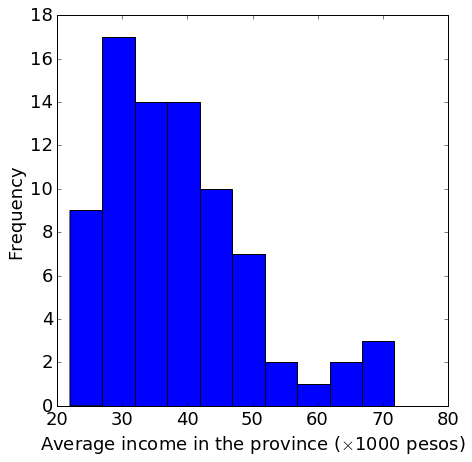

In [7]:
df.gdp_pc_pp.plot.hist(figsize=(7,7))
plt.xlabel("Average income in the province ($\\times$1000 pesos)");

And below is a scatter plot showing average income, poverty incidence, and size (population) of each province

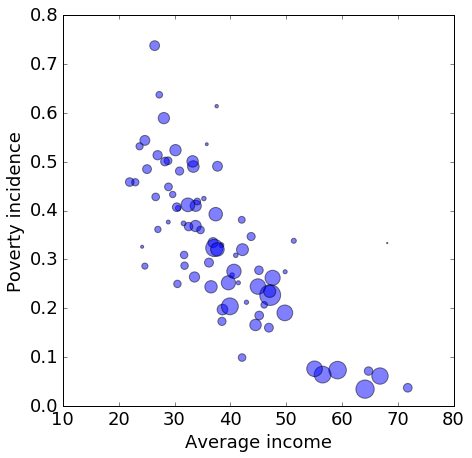

In [8]:
df.plot.scatter(x="gdp_pc_pp", y="pov_head", s=df["pop"]/1e4, alpha=0.5, figsize=(7,7))
plt.xlabel("Average income")
plt.ylabel("Poverty incidence")
plt.ylim(0);

# Computing socio-economic capacity

Now that we have minimum familiarity with dataframes, let us use the resilience model. Let us first read the function definitions, from [res_ind_lib.py](res_ind_lib.py)

#### Loading functions

In [9]:
from res_ind_lib import *     #MAIN library: the functions used to compute risk, resilience, etc

#### Defining reference variabes

Before running the model, for technical reasons, we need to define "reference" values for some variables. The following function does it.

In [10]:
df = def_ref_values(df).dropna()
df[["protection", "protectionref"]].head()

,protection,protectionref
province,,
Abra,10.57,10.57
Agusan Del Norte,9.41,9.41
Agusan Del Sur,8.61,8.61
Aklan,2.00,2.00
Albay,2.00,2.00


#### Assessing risk to assets, capacity, and risk to welfare

The function compute_resiliences computes risk and capacity from all the data.

In [11]:
df_with_results=compute_resiliences(df)

Let us look at a few inputs and outputs of that function

In [12]:
#set of variable we want to inspect
to_output = ['gdp_pc_pp', 'pop',"protection","fap","far","v_p","v_r","resilience","risk"] 
a=df_with_results[to_output].copy().dropna()

#expresses fractions in %
a.loc[:,["fap","far","v_p","v_r","resilience","risk"]]*=100 

#replaces column names (model variables) by their meaning (human-readable description)
desc=pd.read_csv("inputs/inputs_info.csv").set_index('key')["descriptor"]
a=a.rename(columns=desc)

#exports the result to an Excel file
a.to_excel("results/main results_simple.xlsx")

#displays the first few lines
a.head()

,Average income in the province,Population,Hazard (protection),"Exposure, poor people","Exposure, non-poor people",Asset vulnerability (poor people),Asset vulnerability (non-poor people),Socio-economic capacity,Expected welfare losses
province,,,,,,,,,
Abra,31.622466,240135.244121,10.57,18.8715,14.941936,15.246329,10,45.764395,1.278271
Agusan Del Norte,43.726667,661728.454375,9.41,36.5700,29.268438,36.370003,10,52.544506,3.124166
Agusan Del Sur,30.897436,677779.682154,8.61,13.1790,9.868232,29.016559,10,38.415307,1.865017
Apayao,37.546356,116022.676390,6.51,0.4600,0.304694,13.193916,10,45.969304,0.045178
Batangas,49.766072,2485002.055465,7.73,0.2645,0.221889,23.035679,10,81.193720,0.013220


Now we add a description to each column (from [inputs/inputs_info.csv](inputs/inputs_info.csv)) and save the resulting table

In [13]:
#read descritpion of each variable
description = pd.read_csv("inputs/inputs_info.csv", index_col="key")["descriptor"]
description.head()

#copy of the results
data = df_with_results.copy()

#adds description line
data.ix["description"]= description

#makes that line part of the index
data=data.T.reset_index().set_index(["description","index"]).T
data.columns.names = ['description', 'variable']

#exports the result to a CSV file
data.to_csv("results/all_data_and_results_simple.csv") #we call that file _simple because it does not rely on multihazard data

#displays the first few provinces, transposed for ease of reading.
data.head().T

,province,Abra,Agusan Del Norte,Agusan Del Sur,Aklan,Albay
description,variable,,,,,
Average income in the province,gdp_pc_pp,31.6225,43.7267,30.8974,30.5157,33.7933
Population,pop,240135,661728,677780,554414,1.2641e+06
Poverty incidence,pov_head,0.373595,0.346715,0.480785,0.249662,0.409587
Access to early warning,shew,0.953416,0.821277,0.821277,0.823003,0.8
National GDP per capita,gdp_pc_pp_nat,42.0346,42.0346,42.0346,42.0346,42.0346
Average income of the province (relative to national),rel_gdp_pp,0.752296,1.04025,0.735047,0.725965,0.80394
Relative income of poor families,share1,0.509132,0.368196,0.521079,0.527598,0.476426
National population,national_pop,8.36502e+07,8.36502e+07,8.36502e+07,8.36502e+07,8.36502e+07
Access to finance for poor people,axfin_p,0.693233,0.49688,0.475969,0.660083,0.551314


#### Visualizing risk to assets, capacity and risk to welfare

Now we visualize risk and resilience acrross provinces, with plots and maps

Risk to assets averages 0% across the 74 provinces in our sample, ranging from 0.0013% to 2%
Socio-economic capacity averages 58% across our sample, ranging from 27.4399% to 133.9636%
Risk to welfare averages 0% across our sample, ranging from 0.0000% to 3.124%


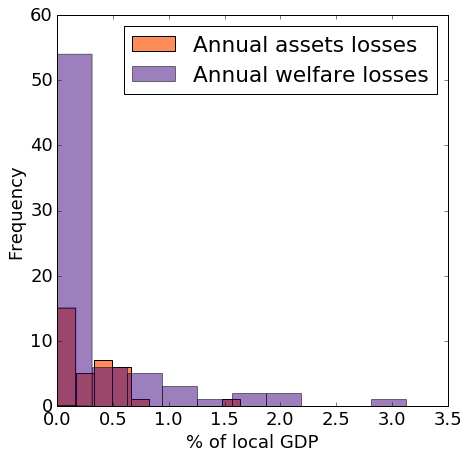

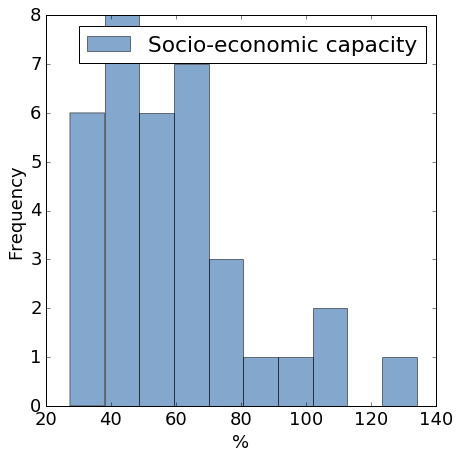

In [14]:
a=df_with_results["risk_to_assets"];
a.min()*100,a.mean()*100,a.max()*100
print("Risk to assets averages {mean:.0%} across the {nb:.0f} provinces in our sample, ranging from {min:.4%} to {max:.0%}".format(
    min=a.min(), nb=a.shape[0],mean=a.mean(),max=a.max()))
ax=(100*a).plot.hist(figsize=(7,7), color="#fc8d59");

a=df_with_results["resilience"];
a.min()*100,a.mean()*100,a.max()*100
print("Socio-economic capacity averages {mean:.0%} across our sample, ranging from {min:.4%} to {max:.4%}".format(
    min=a.min(),mean=a.mean(),max=a.max()))
plt.figure(figsize=(7,7))
ax2=(100*a).plot.hist(alpha=0.5, color="#08519c");
ax2.legend(["Socio-economic capacity"])
ax2.set_xlabel('%');


a=df_with_results["risk"];
a.min()*100,a.mean()*100,a.max()*100
print("Risk to welfare averages {mean:.0%} across our sample, ranging from {min:.4%} to {max:.3%}".format(
    min=a.min(),mean=a.mean(),max=a.max()))
(100*a).plot.hist(alpha=0.5, ax=ax, color="#3f007d");

ax.legend(["Annual assets losses","Annual welfare losses"])
ax.set_xlabel('% of local GDP');

Risk to assets, socio-economic capacity, and total welfare risk can also be visualized in maps (see [draw_maps.ipynb](draw_maps.ipynb) for how to build these maps)

 <table border="0" style="border:none">
  <tr>
  <td>**Risk to assets**</td>
    <td>**Socio-economic capacity**</td>
    <td>**Risk to welfare**</td>
  </tr>
  <tr>
    <td>![title](img/map_and_legend_of_asset_risk.png)</td>
    <td>![title](img/map_and_legend_of_se_capacity.png)</td>
    <td>![title](img/map_and_legend_of_welfare_risk.png)</td>
  </tr>
</table> 


# Categorizing provinces

Here we categorize provinces in 3 tiers (Low, mid, high) according to their ranking on socio-econic capacity and on overall risk to welfare. We use the functions `make_tiers` and `categories_to_formated_excel_file` from [res_ind_lib.py](res_ind_lib.py)

In [15]:
categories = pd.DataFrame([make_tiers(df_with_results.risk_to_assets),
                           make_tiers(df_with_results.resilience),
                           make_tiers(df_with_results.risk), 
                           ]).T.dropna()

categories.rename(columns=description).head()

,Risk to assets,Socio-economic capacity,Expected welfare losses
Abra,High,Low,High
Agusan Del Norte,High,Mid,High
Agusan Del Sur,High,Low,High
Apayao,Low,Low,Mid
Batangas,Low,High,Mid


# Policy experiments

Finally, the resilience indicator model can be used to asses the impact of specific policies on asset and welfare losses. In the following we provide two examples. More policy assessment are performed in [render_policy_assessment.ipynb](render_policy_assessment.ipynb)

#### Impact of increasing the income of poor families

In [16]:
df_share1 = compute_resiliences( def_ref_values(df.dropna().assign(share1=df.share1+5/100) ))

#welfare losses
wa=df_with_results.dWtot_currency.sum()*1e-6
wb=df_share1.dWtot_currency.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot).sum()*1e-6
kb = (df_share1.dKtot).sum()*1e-6

nb_countries_all_results = df_with_results["resilience"].dropna().shape[0]

print(" Increasing the income of poor households by 5 percent in the {nb} provincies \
would increase asset losses from {ka:0.2f} to {kb:0.2f} billions per year\
({XX:.1%}), but reduce welfare losses by {YY:.1%}".format(
        XX=(kb-ka)/ka,ka=ka,kb=kb,YY=(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Increasing the income of poor households by 5 percent in the 35 provincies would increase asset losses from 4.83 to 4.96 billions per year(2.7%), but reduce welfare losses by 3.2%


#### Impact of scaling up social protection

In [17]:
df_su = compute_resiliences( df.dropna().assign(sigma_p=.33,sigma_r=0.33) )

#welfare losses
wa=df_with_results.dWtot_currency.sum()*1e-6
wb=df_su.dWtot_currency.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot).sum()*1e-6
kb = (df_su.dKtot).sum()*1e-6

print("Scaling up social protection to cover one third of asset losses in the {nb} provincies \
would left asset losses unchanged (from {ka:0.2f} to {kb:0.2f} billions per year), \
but reduce welfare losses by {YY:.0%}".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=(wb-wa)/wb,nb=nb_countries_all_results)
     )

Scaling up social protection to cover one third of asset losses in the 35 provincies would left asset losses unchanged (from 4.83 to 4.83 billions per year), but reduce welfare losses by -15%


In [18]:
compute_resiliences(df)

,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,national_pop,axfin_p,axfin_r,...,dK,delta_W,dcap,dcar,dKtot,dWpc_curency,risk,dWtot_currency,resilience,risk_to_assets
province,,,,,,,,,,,,,,,,,,,,,
Abra,31.622466,240135.244121,0.373595,0.953416,42.034627,0.752296,0.509132,83650215.459496,0.693233,0.693233,...,1.955336,1.752822,5.544358,9.384394,44422.431961,0.404221,0.012783,97067.669262,0.457644,0.005850
Agusan Del Norte,43.726667,661728.454375,0.346715,0.821277,42.034627,1.040253,0.368196,83650215.459496,0.496880,0.496880,...,6.754565,5.273686,13.851699,15.393899,474993.394033,1.366094,0.031242,903982.977995,0.525445,0.016416
Agusan Del Sur,30.897436,677779.682154,0.480785,0.821277,42.034627,0.735047,0.521079,83650215.459496,0.475969,0.475969,...,1.905955,2.035413,10.687984,10.538564,150036.900584,0.576242,0.018650,390565.404291,0.384153,0.007165
Aklan,30.515652,554414.442422,0.249662,0.823003,42.034627,0.725965,0.527598,83650215.459496,0.660083,0.660083,...,0.000000,0.000000,12.914188,9.825836,0.000000,0.000000,0.000000,0.000000,NaN,NaN
Albay,33.793313,1264097.894966,0.409587,0.800000,42.034627,0.803940,0.476426,83650215.459496,0.551314,0.551314,...,0.000000,0.000000,11.914162,10.031005,0.000000,0.000000,0.000000,0.000000,NaN,NaN
Antique,31.712499,561980.471779,0.308969,0.823003,42.034627,0.754437,0.507686,83650215.459496,0.437850,0.437850,...,0.000000,0.000000,12.026692,9.980566,0.000000,0.000000,0.000000,0.000000,NaN,NaN
Apayao,37.546356,116022.676390,0.613667,0.953416,42.034627,0.893224,0.428803,83650215.459496,0.261280,0.261280,...,0.050762,0.045302,4.430535,14.931870,904.696481,0.016963,0.000452,1968.044750,0.459693,0.000208
Aurora,40.970820,207219.483546,0.308317,1.003452,42.034627,0.974692,0.392963,83650215.459496,0.573358,0.573358,...,0.000000,0.000000,6.525655,11.178186,0.000000,0.000000,0.000000,0.000000,NaN,NaN
Basilan,27.012152,404023.538097,0.361237,0.661996,42.034627,0.642617,0.596028,83650215.459496,0.538168,0.538168,...,0.000000,0.000000,17.549602,10.384963,0.000000,0.000000,0.000000,0.000000,NaN,NaN
